In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

## Check Data

In [2]:
labels = pd.read_csv('dataset/labels.csv')

In [3]:
labels

,Name,ClassID
0,Speed limit (5km/h),0
1,Speed limit (40km/h),1
2,Speed limit (60km/h),2
3,speed limit (80km/h),3
4,Dont Go Left,4
5,Dont overtake from Left,5
6,No Car,6
7,No horn,7
8,keep Right,8
9,watch out for cars,9


In [4]:
def display_images_with_labels(dataset_dir, labels):
    num_labels = len(labels)
    num_cols = math.ceil(num_labels / 2)
    fig, axes = plt.subplots(2, num_cols, figsize=(15, 10))
    
    for idx, row in labels.iterrows():
        class_id = row['ClassID']
        label_name = row['Name']
        
        # Get the path to the folder and the first image
        folder_path = os.path.join(dataset_dir, str(class_id))
        img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        
        # Load and display the image
        img = mpimg.imread(img_path)
        ax = axes[idx // num_cols, idx % num_cols]
        ax.imshow(img)
        ax.set_title(label_name)
        ax.axis('off')
    
    # Hide any empty subplots
    for i in range(num_labels, 2 * num_cols):
        fig.delaxes(axes.flat[i])
    
    plt.tight_layout()
    plt.show()

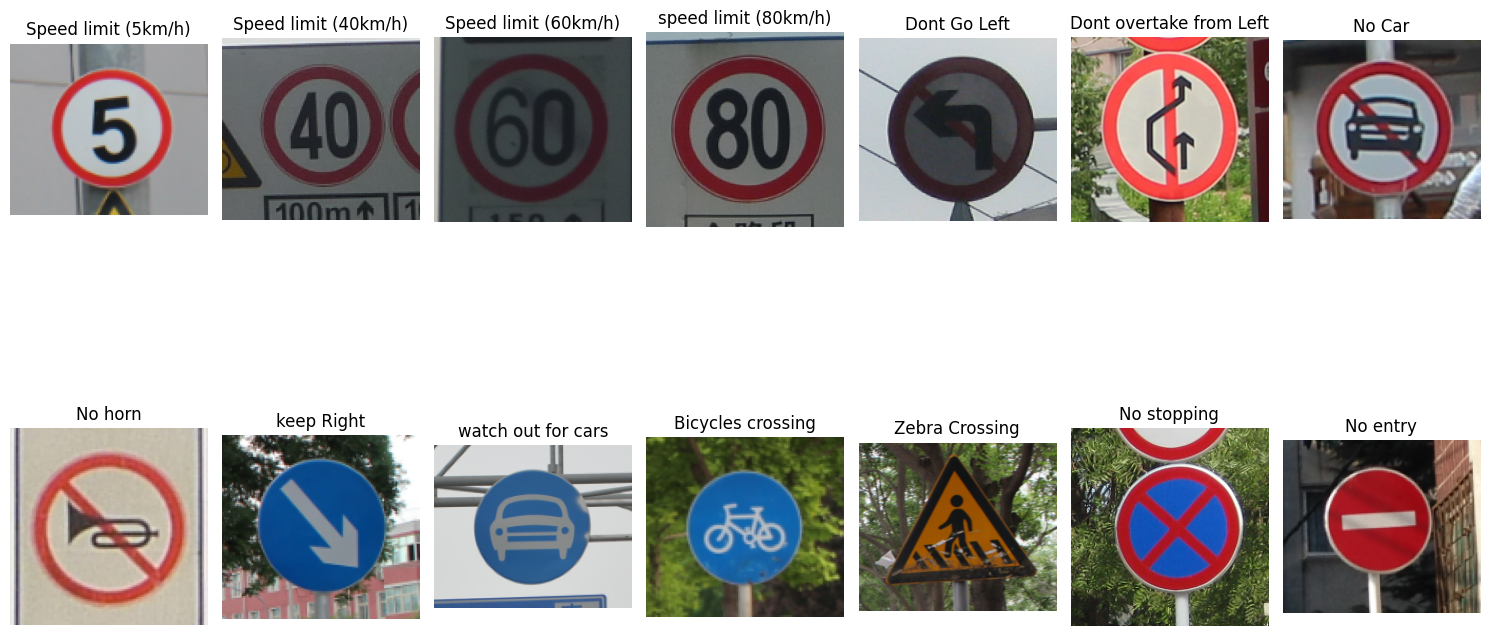

In [5]:
# Display the images with labels
display_images_with_labels('dataset/validate',labels)

In [6]:
train_path = 'dataset/train'

# List all class folders
class_folders = os.listdir(train_path)

# Count the number of images in each class folder
class_counts = {}

for class_folder in class_folders:
    class_folder_path = os.path.join(train_path, class_folder)
    if os.path.isdir(class_folder_path):
        num_images = len(os.listdir(class_folder_path))
        class_counts[class_folder] = num_images

# Create a DataFrame from the counts
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['ClassID', 'Count'])

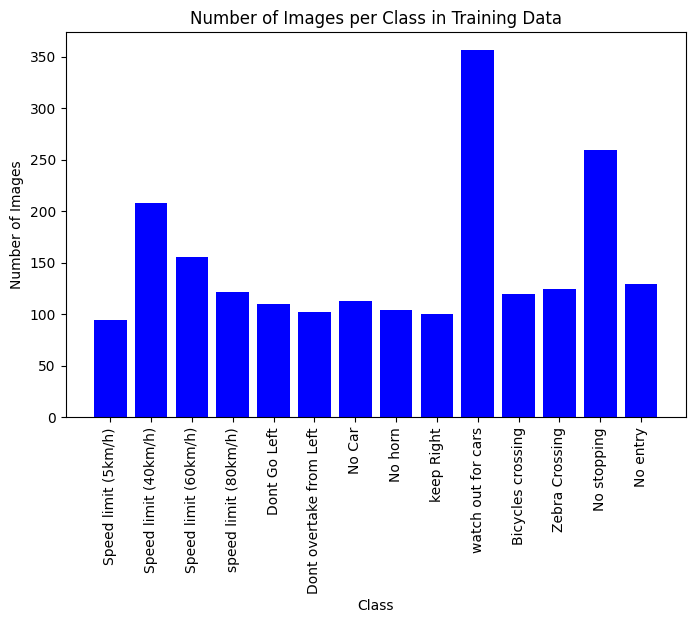

In [7]:
# Load labels to map ClassID to Name
labels_path = 'dataset/labels.csv'
labels = pd.read_csv(labels_path)

# Ensure ClassID is int in both DataFrames for merging
class_counts_df['ClassID'] = class_counts_df['ClassID'].astype(int)
labels['ClassID'] = labels['ClassID'].astype(int)

# Merge DataFrames
class_counts_df = class_counts_df.merge(labels, on='ClassID')

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_counts_df['Name'], class_counts_df['Count'], color='Blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Data')
plt.xticks(rotation=90)
plt.show()

## VGG16 Transfer Learning

In [8]:
import numpy as np
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

2024-06-09 13:52:52.835398: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 13:52:52.876055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 13:52:52.876084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 13:52:52.876132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 13:52:52.884934: I tensorflow/core/platform/cpu_feature_g

In [9]:
# Load the labels
labels_path = 'dataset/labels.csv'
labels = pd.read_csv(labels_path)
num_classes = len(labels)
print("number of classes : ", num_classes)

number of classes :  14


In [10]:
train_batches = ImageDataGenerator().flow_from_directory('dataset/train', 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory('dataset/validate',
                                                         target_size=(224,224), 
                                                         batch_size=30)

Found 2095 images belonging to 14 classes.
Found 531 images belonging to 14 classes.


In [11]:
#Load model
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

2024-06-09 13:52:55.896819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:bb:00.0, compute capability: 9.0
2024-06-09 13:52:55.898533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79195 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cb:00.0, compute capability: 9.0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-10]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')
last_output = last_layer.output
x = Dense(num_classes, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
model_v1 = Model(inputs=base_model.input, outputs=x)

model_v1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Train Level 1 Model

In [14]:
model_v1.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='traffic.v1.model.hdf5', save_best_only=True)

history_one = model_v1.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=10, verbose=1, callbacks=[checkpointer])

Epoch 1/10


2024-06-09 13:52:58.444646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-09 13:52:58.757488: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc829c8fb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 13:52:58.757519: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 9.0
2024-06-09 13:52:58.757524: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 9.0
2024-06-09 13:52:58.761969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 13:52:58.840715: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 4s 92ms/step - loss: 3.1326 - accuracy: 0.2778 - val_loss: 2.3885 - val_accuracy: 0.3222
Epoch 2/10
18/18 [==============================] - 1s 50ms/step - loss: 1.8503 - accuracy: 0.4333 - val_loss: 1.3264 - val_accuracy: 0.5556
Epoch 3/10
18/18 [==============================] - 1s 49ms/step - loss: 1.2360 - accuracy: 0.5889 - val_loss: 0.8291 - val_accuracy: 0.7222
Epoch 4/10
18/18 [==============================] - 1s 29ms/step - loss: 0.7847 - accuracy: 0.7833 - val_loss: 0.9423 - val_accuracy: 0.7111
Epoch 5/10
18/18 [==============================] - 1s 50ms/step - loss: 0.7628 - accuracy: 0.7333 - val_loss: 0.7393 - val_accuracy: 0.7000
Epoch 6/10
18/18 [==============================] - 1s 49ms/step - loss: 0.4919 - accuracy: 0.8500 - val_loss: 0.3765 - val_accuracy: 0.8778
Epoch 7/10
18/18 [==============================] - 1s 49ms/step - loss: 0.2432 - accuracy: 0.9278 - val_loss: 0.1181 - val_accuracy: 0.9667
Epoch 8/10
18/18 [======

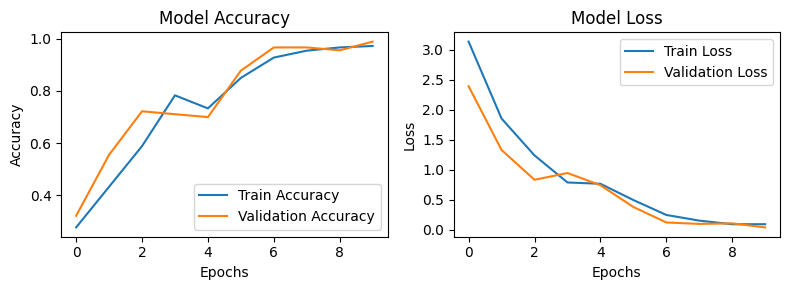

In [16]:
def plot_training_history(history, figsize=(8, 3)):

    plt.figure(figsize=figsize)

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()
plot_training_history(history_one)

#### Create the confusion matrix to evaluate the model

In [17]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [18]:
from sklearn.datasets import load_files
from keras.utils import to_categorical
import numpy as np

data = load_files('dataset/validate')
test_files = np.array(data['filenames'])
test_targets = to_categorical(np.array(data['target']))

In [19]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100% 531/531 [00:00<00:00, 701.38it/s]


In [20]:
# Load the model weights
model_v1.load_weights('traffic.v1.model.hdf5')

# Evaluate the model on the test data
test_loss, test_accuracy = model_v1.evaluate(test_tensors, test_targets)
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(test_loss, test_accuracy))

17/17 [==============================] - 1s 20ms/step - loss: 1.0608 - accuracy: 0.7627

Testing loss: 1.0608
Testing accuracy: 0.7627


In [21]:
# Create a mapping from ClassID to Name

class_id_to_name = dict(zip(labels['ClassID'], labels['Name']))

In [22]:
class_id_to_name

{0: 'Speed limit (5km/h)',
 1: 'Speed limit (40km/h)',
 2: 'Speed limit (60km/h)',
 3: 'speed limit (80km/h)',
 4: 'Dont Go Left',
 5: 'Dont overtake from Left',
 6: 'No Car',
 7: 'No horn',
 8: 'keep Right',
 9: 'watch out for cars',
 10: 'Bicycles crossing',
 11: 'Zebra Crossing',
 12: 'No stopping',
 13: 'No entry'}

17/17 [==============================] - 0s 12ms/step


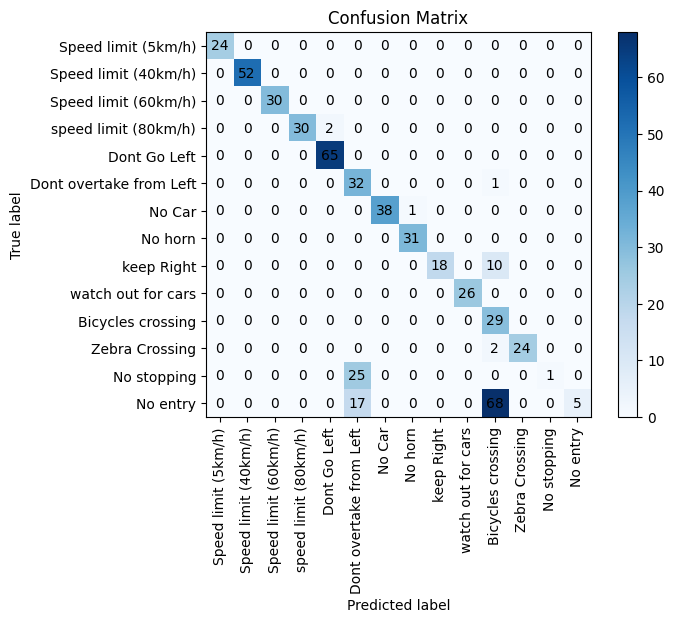

In [23]:
def plot_confusion_matrix(model, test_tensors, test_targets, class_id_to_name):
    # Predict on test data
    test_pred = model.predict(test_tensors)

    # Convert predictions and true labels to class indices
    test_y_pred = np.argmax(test_pred, axis=1)
    test_y_true = np.argmax(test_targets, axis=1)

    # Update confusion matrix labels to use class names
    num_classes = len(class_id_to_name)
    cm_labels = [class_id_to_name[i] for i in range(num_classes)]

    # Generate confusion matrix
    cm = confusion_matrix(test_y_true, test_y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    indexes = np.arange(len(cm_labels))
    for i in indexes:
        for j in indexes:
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xticks(indexes, cm_labels, rotation=90)
    plt.xlabel('Predicted label')
    plt.yticks(indexes, cm_labels)
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show
    
plot_confusion_matrix(model_v1, test_tensors, test_targets, class_id_to_name)

#### Train Level 2 Model 

In [24]:
# Reset all layers to be trainable
for layer in base_model.layers:
    layer.trainable = True

# Freeze lower 5 layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')
last_output = last_layer.output
x = Dense(num_classes, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
model_v2 = Model(inputs=base_model.input, outputs=x)

model_v2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### Train Model V2

In [26]:
model_v2.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='traffic.v2.model.hdf5', save_best_only=True)

history_two = model_v2.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=10, verbose=1, callbacks=[checkpointer])

Epoch 1/10
18/18 [==============================] - 2s 55ms/step - loss: 3.9710 - accuracy: 0.4111 - val_loss: 1.4099 - val_accuracy: 0.4444
Epoch 2/10
18/18 [==============================] - 1s 44ms/step - loss: 1.0210 - accuracy: 0.6889 - val_loss: 0.8732 - val_accuracy: 0.7778
Epoch 3/10
18/18 [==============================] - 1s 43ms/step - loss: 0.6891 - accuracy: 0.8056 - val_loss: 0.5062 - val_accuracy: 0.8333
Epoch 4/10
18/18 [==============================] - 1s 45ms/step - loss: 0.4720 - accuracy: 0.8722 - val_loss: 0.2822 - val_accuracy: 0.8889
Epoch 5/10
18/18 [==============================] - 1s 42ms/step - loss: 0.2854 - accuracy: 0.9222 - val_loss: 0.1544 - val_accuracy: 0.9667
Epoch 6/10
18/18 [==============================] - 1s 30ms/step - loss: 0.1360 - accuracy: 0.9556 - val_loss: 0.3069 - val_accuracy: 0.9222
Epoch 7/10
18/18 [==============================] - 1s 43ms/step - loss: 0.0616 - accuracy: 0.9889 - val_loss: 0.0938 - val_accuracy: 0.9667
Epoch 8/10
18

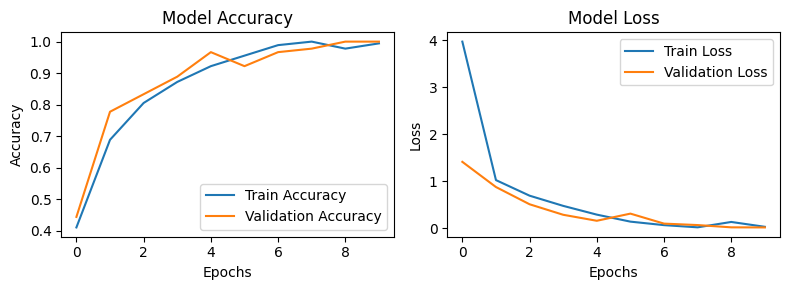

In [28]:
plot_training_history(history_two)

In [29]:
# Load the model weights
model_v2.load_weights('traffic.v2.model.hdf5')

# Evaluate the model on the test data
test_loss, test_accuracy = model_v2.evaluate(test_tensors, test_targets)
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(test_loss, test_accuracy))

17/17 [==============================] - 0s 12ms/step - loss: 0.2826 - accuracy: 0.8964

Testing loss: 0.2826
Testing accuracy: 0.8964


17/17 [==============================] - 0s 12ms/step


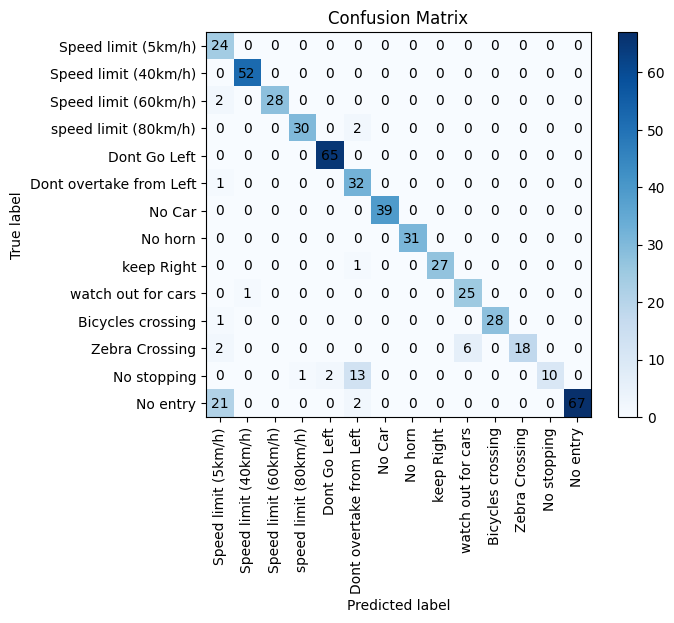

In [30]:
plot_confusion_matrix(model_v2, test_tensors, test_targets, class_id_to_name)

### Conclusion